Importing Necessary Libraries

In [31]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf

import warnings
warnings.filterwarnings('ignore')

Loading the dataset

In [32]:
train_df = pd.read_csv('train.csv')
msp_df = pd.read_csv('msp.csv')

Converting all commodity names to lower case for uniformity in both input datasets

In [33]:
train_df['Commodity'] = train_df['Commodity'].str.lower()
msp_df['commodity'] = msp_df['commodity'].str.lower()

Converting the date to datetime datatype

In [34]:
train_df['date'] =  pd.to_datetime(train_df['date'])

Function takes in a dataframe which has an APMC-Commodity pair's modal price and date, and the kind of decomposition ( additive or multiplicative). It then plots the seasonal decomposition

In [35]:
def plot_decomposition(df,decomposition_type):
    
    series = df.values
    result = seasonal_decompose(df.values, model=decomposition_type, freq =3)
    result.plot()
    plt.show()

Let us test the above function by plotting the trend, seasonality and residual of Cabbage prices in Mumbai with
a frequency of 3 months

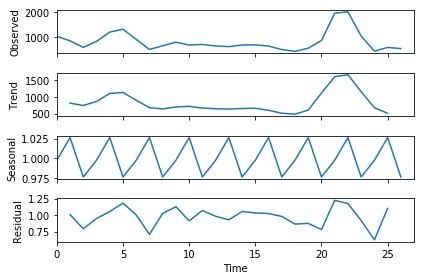

In [36]:
df = train_df.groupby(['Commodity','APMC']).get_group(('cabbage','Mumbai'))[['date','modal_price']]
df = df.set_index('date')
df.sort_index(inplace=True)
plot_decomposition(df,'multiplicative')

We can see that there is a strong seasonal component in here. However, we assumed multiplicative decomposition here.
The next function decides which decomposition is better ( additive or multiplicative) by finding out the Auto-
Correlation factor of residuals obtained after assuming both additive and multiplicative decomposition. The one
with the lesser acf is obviously the better decomposition.

In [37]:
def better_decomposition_type(df):
    
    mul = seasonal_decompose(df.values, model='multiplicative', freq =3).resid[1:-1] # slicing done to remove nans
    addi = seasonal_decompose(df.values, model='additive', freq =3).resid[1:-1] #slicing done to remove nans
    
    mul_total_acf = np.linalg.norm(acf(mul)) #finding out the auto-correlation factor for multiplicative residuals.
    addi_total_acf = np.linalg.norm(acf(addi)) # and getting their L2 norm (to avoid negative values)
    
    if(mul_total_acf<addi_total_acf): # the decomposition with lesser acf in residuals is better.
        return 'multiplicative'
    else:
        return 'additive'
    

Let us use the above function to see whether the seasonality of Cabbage prices in Mumbai with
a frequency of 3 months is additive or multiplicative

In [38]:
better_decomposition_type(df)

'multiplicative'

Great. So, now we can pass as many pairs of APMC and Commodities to our functions which will allow us
to both visualise the seasonality, trend and residue and also find which seasonality decomposition works better
for each.

We make a parent function that takes in the whole dataframe, commodity and APMC as input and uses the above
two functions as helper functions to first find which decomposition is better for the given pair and then
plot the seasonality, trend and residual of the same.

In [39]:
def detect_seasonality_type(data,commodity,APMC):

    df = data.groupby(['Commodity','APMC']).get_group((commodity,APMC))[['date','modal_price']]
    df = df.set_index('date')
    df.sort_index(inplace=True)

    result = better_decomposition_type(df)
    print(result)

    plot_decomposition(df,result)

Let us run a few more cases.

additive


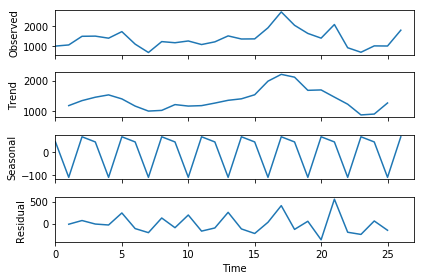

In [40]:
detect_seasonality_type(train_df, 'cucumber', 'Pune')

So, Cucumber prices in Pune have an additive seasonality along with the trend as shown in the plot

multiplicative


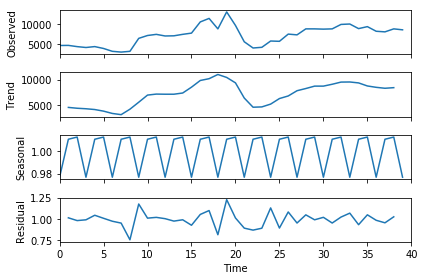

In [41]:
detect_seasonality_type(train_df,'garlic','Nagpur')

And Garlic prices in Nagpur have multiplicative decomposition!